In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [4]:
cd /content/drive/MyDrive/2048_progress

/content/drive/MyDrive/2048_progress


In [5]:
import math, random
from collections import deque

import game_2048
import Group

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
#m1에서 돌릴 때 GPU 사용을 위한 code...I'll do later.
#mps_device = torch.device("mps")

In [8]:
#Hyper Parameters
batch_size = 256
gamma = 0.99
copy_rate = 10

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state,0)
        next_state = np.expand_dims(next_state,0)
        
        self.buffer.append((state,action,reward,next_state,done)) #deque에 numpy arr이 들어간다는 사실
        
    def sample(self,batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [11]:
env = game_2048.Game2048()

In [12]:
epsilon_start = 1.0
epsilon_final = 0.001
epsilon_decay = 10000

#단순 1/500이 아니라 exp(-x/500)
epsilon_by_frame = lambda frame_idx : epsilon_final + (epsilon_start - epsilon_final)*math.exp(-1.*frame_idx/epsilon_decay)


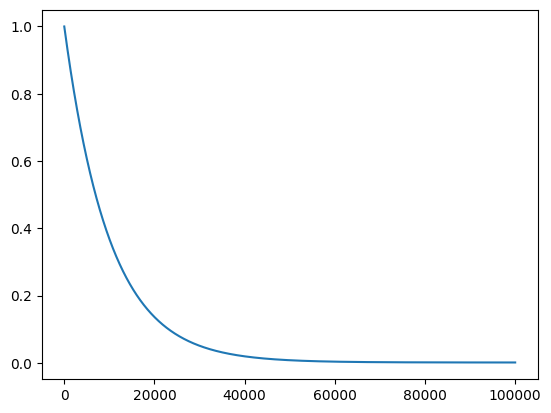

In [13]:
plt.plot([epsilon_by_frame(i) for i in range(100000)])

# Deep Q Network

In [26]:
class DQN(nn.Module):
    def __init__(self,num_inputs,num_actions):
        super(DQN, self).__init__() #nn.Module class의 init
        
        #함수 pointer 같은 것
        self.layer1 = nn.Sequential(
            nn.Conv2d(16,256,kernel_size=2,padding=0),
            nn.GELU(),
            nn.Conv2d(256,512,kernel_size=2,padding=0),
            nn.GELU(),
          )
    
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,256,kernel_size=3),
            nn.GELU(),
          )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16,256,kernel_size=4,padding = 0), #Output : Batchsize*128*1x1
            nn.GELU(),
          )
        size = 2*2*512+2*2*256+1*1*256
        self.layer_fc = nn.Sequential(
            nn.Linear(size,1024),
            nn.GELU(),
            nn.Linear(1024,512),
            nn.GELU(),
            nn.Linear(512,128),
            nn.GELU(),
            nn.Linear(128,64),
            nn.GELU(),
            nn.Linear(64,num_actions)
        )
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x3 = self.layer3(x)
        
        x1 = x1.view(-1,x1.shape[1]*x1.shape[2]*x1.shape[3])
        x2 = x2.view(-1,x2.shape[1]*x2.shape[2]*x2.shape[3])
        x3 = x3.view(-1,x3.shape[1]*x3.shape[2]*x3.shape[3])
        x = torch.cat((x1,x2,x3),dim=1)
        
        return self.layer_fc(x)

    def act(self,state,epsilon):
        #epsilon-greedy
        if np.random.rand(1)[0] > epsilon:
            state = torch.tensor(state,dtype=torch.float32)
            state = state.to(device)
            
            state = state.unsqueeze(0)
            q_value = self.forward(state)
            #1X2로부터 최대를 구하기 위해 row의 최대 .max(1) max인 것의[1]은 idx, 요거는 하나이므로 .data[0]
            action = int(q_value.max(1)[1]) #q_value의 second dim에서 Q_value와 index를 묶은 tuple을

        else:
            action = random.randrange(4)
        return action

In [27]:
local_network = DQN(16,4)
target_network = DQN(16,4)

local_network = local_network.to(device)
target_network = target_network.to(device)

optimizer = optim.Adam(local_network.parameters())

replay_buffer = ReplayBuffer(1024)

In [28]:
from torchsummary import summary
summary(DQN(16,4).to(device), (16, 4, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 256, 3, 3]          16,640
              GELU-2            [-1, 256, 3, 3]               0
            Conv2d-3            [-1, 512, 2, 2]         524,800
              GELU-4            [-1, 512, 2, 2]               0
            Conv2d-5            [-1, 256, 2, 2]          37,120
              GELU-6            [-1, 256, 2, 2]               0
            Conv2d-7            [-1, 256, 1, 1]          65,792
              GELU-8            [-1, 256, 1, 1]               0
            Linear-9                 [-1, 1024]       3,408,896
             GELU-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
             GELU-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
             GELU-14                  [

# Computing Temporal Difference Loss

In [29]:
def compute_td_loss(batch_size):
    local_network.train()

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    #State
    state = torch.tensor(state,dtype=torch.float32).to(device)
    state = state.view([batch_size,-1,4,4])
    next_state = torch.tensor(next_state,dtype=torch.float32).to(device)
    next_state = state.view([batch_size,-1,4,4])
    
    #Action
    action = torch.tensor(action,dtype=torch.int64).unsqueeze(1)
    action = action
    action = action.to(device)
    
    #Reward
    reward = torch.tensor(reward,dtype=torch.float32).to(device)
    done = torch.tensor(done,dtype=torch.float32).to(device)
    
    #q_values
    q_values = local_network(state)
    next_q_values = target_network(next_state)
    q_value = torch.gather(q_values,1,action)
    next_q_value = next_q_values.max(1)[0] #제일 큰 값으로 선택
    
    #Calculation
    expected_q_value = reward + gamma *next_q_value*(1-done)
    q_value = q_value.squeeze(1)
    loss_func = nn.MSELoss()
    loss = loss_func(expected_q_value,q_value)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss
    

In [30]:
def plot(frame_idx,losses,rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episodes: %s. reward: %s' % (frame_idx,rewards[-1]))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

# Training

In [31]:
losses = []
all_rewards = deque(maxlen = 10)
mean_rewards = [0]
episode_reward = 0
count = 0
env.reset()
maximum_reward = 0
#best_model_params_path = "/content/drive/MyDrive/2048 Final/DDQN.pt"
best_model_params_path = "./DDQN2.pt"
episodes = 1000
frame_idx = 0
episode = 0

In [ ]:
state = env.board
while(episode<episodes):
    epsilon = epsilon_by_frame(frame_idx) #epsilon update
    
    local_network.eval()
    with torch.no_grad():
        #Grid processing
        convert_direction = Group.representative(state)
        converted_state = Group.rotate(state,convert_direction)
        converted_state = Group.OneHotEncoding(converted_state)
        
        converted_action = local_network.act(converted_state,epsilon)
        action = Group.action_convert(convert_direction,converted_action)
    
    next_state, reward, done = env.step(int(action))
    
    convert_direction = Group.representative(next_state)
    converted_next_state = Group.rotate(next_state,convert_direction)
    converted_next_state = Group.OneHotEncoding(converted_next_state)

    replay_buffer.push(converted_state,converted_action,reward,converted_next_state,done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        env.reset()
        state = env.board
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode += 1
        
        if episode % 10 == 0:
            mean_rewards.append(np.mean(all_rewards))
            plot(episode, losses,mean_rewards)
        
        if(maximum_reward<mean_rewards[-1]):
            maximum_reward = mean_rewards[-1]
            torch.save(local_network.state_dict(),best_model_params_path)
    
    if frame_idx % copy_rate== 0:
        target_network.load_state_dict(local_network.state_dict())
    
    if len(replay_buffer.buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        #print(loss)
        losses.append(loss.item())
    
    frame_idx += 1

In [ ]:
#epsilon 10000 1 10000 20000(200000회, 최소 0.1) 20000(200000회, 최소 0.1) 10(0.05) 0.5(0.05) 0.5(0.01)
#loss가 뛰는 순간 reward가 감소한다. - 새로운걸 학습한다는건가?

In [ ]:
qvalue = torch.tensor([1,2,3,4],dtype = torch.float32)

In [ ]:
qvalue.max(0)[1]

In [ ]:
maximum_reward = 0
best_model_params_path = "/content/drive/MyDrive/2048 Final"
if(maximum_reward<mean_rewards[-1]):
  maximum_reward = mean_rewards[-1]
  torch.save(local_network.state_dict(),best_model_params_path)

1800 달성 모델

In [ ]:
class DQN(nn.Module):
    def __init__(self,num_inputs,num_actions):
        super(DQN, self).__init__() #nn.Module class의 init
        
        #함수 pointer 같은 것
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(32),
          )
        self.layer_fc = nn.Sequential(
            nn.Linear(1024,512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,50),
            nn.GELU(),
            nn.BatchNorm1d(50),
            nn.Linear(50,num_actions),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,48,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(48),
            nn.Conv2d(48,64,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(64),
          )
        
    def forward(self, x):
        x = self.layer1(x)+x
        x = self.layer2(x)
        x = x.view(-1,16*64)
        return self.layer_fc(x)

    def act(self,state,epsilon):
        #epsilon-greedy
        if np.random.rand(1)[0] > epsilon:
            state = torch.tensor(state,dtype=torch.float32)#0번 자리에 차원 하나 추가
            state = state.to(device)
            #state = torch.flatten(state)
            state = state.unsqueeze(0)
            state = state.unsqueeze(0)
            q_value = self.forward(state)
            #1X2로부터 최대를 구하기 위해 row의 최대 .max(1) max인 것의[1]은 idx, 요거는 하나이므로 .data[0]
            action = int(q_value.max(1)[1]) #q_value의 second dim에서 Q_value와 index를 묶은 tuple을

        else:
            action = random.randrange(4)
        return action